In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.dimred import CORE
from scipy.linalg import eigh
from matplotlib.patches import Ellipse
from scipy.stats.distributions import chi2
from statsmodels.nonparametric.smoothers_lowess import lowess

C:\Users\rajnishk\AppData\Local\Temp\ipykernel_23596\3512092547.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv(r'C:\Users\rajnishk\OneDrive - Michigan Medicine\Documents\Student Wellness Dataset\student_wellness_sleep_details.csv',
                 parse_dates=["SLEEP_DATE","SLEEP_START_DATE", "SLEEP_END_DATE"])

# df = pd.read_csv("/home/kshedden/data/Sung_Choi/student_wellness/student_wellness_sleep_details.csv.gz",
                 # parse_dates=["SLEEP_DATE", "SLEEP_START_DATE", "SLEEP_END_DATE"])

In [3]:
df_W7LX2I74 = df[df.STUDY_PRTCPT_ID=='W7LX2I74']
# df_W7LX2I74

In [4]:
# df_W7LX2I74[df_W7LX2I74.SLEEP_DATE == '2023-04-21']
df.columns

Index(['Unnamed: 0', 'SLEEP_SUMMARY_ID', 'STUDY_PRTCPT_ID', 'STUDY_ID',
       'SLEEP_DATE', 'SLEEP_START_DATE', 'SLEEP_END_DATE', 'ASLEEP_VALUE',
       'INBED_VALUE', 'DEEP_MIN', 'DEEP_COUNT', 'LIGHT_MIN', 'LIGHT_COUNT',
       'REM_MIN', 'REM_COUNT', 'WAKE_MIN', 'WAKE_COUNT', 'ASLEEP_MIN',
       'ASLEEP_COUNT', 'AWAKE_COUNT', 'AWAKE_MIN', 'RESTLESS_COUNT',
       'RESTLESS_MIN', 'TYPE'],
      dtype='object')

In [5]:
df_classic = df[df.TYPE == 'classic']
# df_classic

In [6]:
sleep_vars_classic = ['SLEEP_SUMMARY_ID', 'STUDY_PRTCPT_ID', 'STUDY_ID',
       'SLEEP_DATE', 'SLEEP_START_DATE', 'SLEEP_END_DATE','ASLEEP_VALUE', 'INBED_VALUE',  'ASLEEP_MIN', 'ASLEEP_COUNT', 
              'AWAKE_COUNT', 'AWAKE_MIN', 'RESTLESS_COUNT', 'RESTLESS_MIN', 'TYPE']

In [7]:
df_classic = df_classic[sleep_vars_classic]
# df_classic

Keep only the sleep-relevant variables.  Convert the sleep start time and day of year into polar coordinates.

In [8]:
sleep_vars = ['ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN', 'DEEP_COUNT', 'LIGHT_MIN', 'LIGHT_COUNT', 
              'REM_MIN', 'REM_COUNT', 'WAKE_MIN', 'WAKE_COUNT', 'ASLEEP_MIN', 'ASLEEP_COUNT', 
              'AWAKE_COUNT', 'AWAKE_MIN', 'RESTLESS_COUNT', 'RESTLESS_MIN']
v = df[sleep_vars].isna().sum(0)
v = v[v < 500].index.tolist()
vv = ["STUDY_PRTCPT_ID", "SLEEP_START_DATE", "SLEEP_DATE"] + v
dx = df[vv].copy()
dx["YEARDAY"] = dx["SLEEP_DATE"].dt.dayofyear
dx["DAYOFWEEK"] = dx["SLEEP_DATE"].dt.dayofweek
dx["SLEEP_START_TIME"] = (dx["SLEEP_START_DATE"] - dx["SLEEP_START_DATE"].dt.normalize()) / pd.Timedelta(hours=1)
dx["SLEEP_START_SIN"] = np.sin(2*np.pi*dx["SLEEP_START_TIME"]/24)
dx["SLEEP_START_COS"] = np.cos(2*np.pi*dx["SLEEP_START_TIME"]/24)
dx["YEARDAY_SIN"] = np.sin(2*np.pi*dx["YEARDAY"]/366)
dx["YEARDAY_COS"] = np.cos(2*np.pi*dx["YEARDAY"]/366)
dx["STUDYDAY"] = dx["YEARDAY"] - dx.groupby("STUDY_PRTCPT_ID")["YEARDAY"].transform(np.min)
dx = dx.drop(columns=["SLEEP_START_DATE", "SLEEP_START_TIME", "SLEEP_DATE"])
dx = dx.dropna()
dx.columns

C:\Users\rajnishk\AppData\Local\Temp\ipykernel_23596\1385559314.py:15: FutureWarning: The provided callable <function min at 0x000001B1F9331EE0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  dx["STUDYDAY"] = dx["YEARDAY"] - dx.groupby("STUDY_PRTCPT_ID")["YEARDAY"].transform(np.min)


Index(['STUDY_PRTCPT_ID', 'ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN',
       'DEEP_COUNT', 'LIGHT_MIN', 'LIGHT_COUNT', 'REM_MIN', 'REM_COUNT',
       'WAKE_MIN', 'WAKE_COUNT', 'YEARDAY', 'DAYOFWEEK', 'SLEEP_START_SIN',
       'SLEEP_START_COS', 'YEARDAY_SIN', 'YEARDAY_COS', 'STUDYDAY'],
      dtype='object')

In [9]:
print("list v is :%s" %v)

list v is :['ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN', 'DEEP_COUNT', 'LIGHT_MIN', 'LIGHT_COUNT', 'REM_MIN', 'REM_COUNT', 'WAKE_MIN', 'WAKE_COUNT']


In [10]:
dx

STUDY_PRTCPT_ID  ASLEEP_VALUE  INBED_VALUE  DEEP_MIN  DEEP_COUNT  \
0           XGJ8AFS8           485          580      67.0         5.0   
1           XGJ8AFS8           587          682      59.0         6.0   
2           XGJ8AFS8           561          690      71.0         5.0   
3           XGJ8AFS8           458          508      91.0         4.0   
5           XGJ8AFS8           492          611      44.0         4.0   
...              ...           ...          ...       ...         ...   
2260        JU3R5P4M           413          482      65.0         3.0   
2261        JU3R5P4M           303          355      64.0         4.0   
2262        JU3R5P4M           191          217      25.0         1.0   
2263        JU3R5P4M           346          421      65.0         3.0   
2264        JU3R5P4M           345          417      48.0         5.0   

      LIGHT_MIN  LIGHT_COUNT  REM_MIN  REM_COUNT  WAKE_MIN  WAKE_COUNT  \
0         320.0         25.0     98.0        9.0      95.0        28.0   
1         423.0         40.0    105.0        8.0      95.0        40.0   
2         394.0         40.0     96.0        7.0     129.0        37.0   
3         243.0         31.0    124.0       11.0      50.0        33.0   
5         360.0         30.0     88.0        9.0     119.0        29.0   
...         ...          ...      ...        ...       ...         ...   
2260      277.0         35.0     71.0        8.0      69.0        36.0   
2261      179.0         17.0     60.0        5.0      52.0        15.0   
2262      161.0         22.0      5.0        1.0      26.0        20.0   
2263      229.0         25.0     52.0        2.0      75.0        21.0   
2264      275.0         29.0     22.0        4.0      72.0        31.0   

      YEARDAY  DAYOFWEEK  SLEEP_START_SIN  SLEEP_START_COS  YEARDAY_SIN  \
0          21          5        -0.848048         0.529919     0.352752   
1          22          6        -0.783964         0.620806     0.368763   
2          23          0        -0.910864         0.412707     0.384665   
3          24          1        -0.594823         0.803857     0.400454   
5          25          2        -0.817899         0.575362     0.416125   
...       ...        ...              ...              ...          ...   
2260      122          1         0.492424         0.870356     0.866025   
2261      123          2         0.608761         0.793353     0.857315   
2262      123          2        -0.760406        -0.649448     0.857315   
2263      124          3         0.987688         0.156434     0.848351   
2264      125          4         0.774393         0.632705     0.839138   

      YEARDAY_COS  STUDYDAY  
0        0.935717         0  
1        0.929523         1  
2        0.923056         2  
3        0.916317         3  
5        0.909308         4  
...           ...       ...  
2260    -0.500000        36  
2261    -0.514793        37  
2262    -0.514793        37  
2263    -0.529434        38  
2264    -0.543919        39  

[1810 rows x 18 columns]

In [11]:
dx_W7LX2I74 = dx[dx.STUDY_PRTCPT_ID=='W7LX2I74']
dx_W7LX2I74

STUDY_PRTCPT_ID  ASLEEP_VALUE  INBED_VALUE  DEEP_MIN  DEEP_COUNT  \
252        W7LX2I74           300          341      30.0         2.0   
253        W7LX2I74           383          467      29.0         2.0   
254        W7LX2I74           186          220      31.0         3.0   
255        W7LX2I74           334          363      54.0         5.0   
256        W7LX2I74           325          361      61.0         3.0   
..              ...           ...          ...       ...         ...   
513        W7LX2I74           439          489      96.0         3.0   
514        W7LX2I74           213          233      26.0         1.0   
515        W7LX2I74           238          275      41.0         1.0   
516        W7LX2I74           525          550     114.0         6.0   
517        W7LX2I74           441          478      79.0         6.0   

     LIGHT_MIN  LIGHT_COUNT  REM_MIN  REM_COUNT  WAKE_MIN  WAKE_COUNT  \
252      226.0         24.0     44.0        5.0      41.0        24.0   
253      280.0         24.0     74.0        7.0      84.0        20.0   
254      124.0          9.0     31.0        1.0      34.0         8.0   
255      202.0         29.0     78.0        5.0      29.0        25.0   
256      219.0         22.0     45.0        3.0      36.0        23.0   
..         ...          ...      ...        ...       ...         ...   
513      205.0         26.0    138.0       12.0      50.0        30.0   
514      149.0         12.0     38.0        4.0      20.0        13.0   
515      132.0         19.0     65.0        7.0      37.0        16.0   
516      238.0         27.0    173.0        9.0      25.0        24.0   
517      264.0         33.0     98.0       11.0      37.0        28.0   

     YEARDAY  DAYOFWEEK  SLEEP_START_SIN  SLEEP_START_COS  YEARDAY_SIN  \
252       53          2         0.860520         0.509417     0.789418   
253       53          2         0.860520         0.509417     0.789418   
254       54          3         0.963630         0.267238     0.799839   
255       57          6         0.719340         0.694658     0.829677   
256       59          1         0.095846         0.995396     0.848351   
..       ...        ...              ...              ...          ...   
513      273          5         0.660985         0.750400    -0.999668   
514      273          5        -0.904455        -0.426569    -0.999668   
515      275          0         0.891007         0.453990    -0.999963   
516      276          1        -0.106698         0.994291    -0.999668   
517      277          2         0.134851         0.990866    -0.999079   

     YEARDAY_COS  STUDYDAY  
252     0.613856         0  
253     0.613856         0  
254     0.600214         1  
255     0.558244         4  
256     0.529434         6  
..           ...       ...  
513    -0.025748       220  
514    -0.025748       220  
515     0.008583       222  
516     0.025748       223  
517     0.042905       224  

[230 rows x 18 columns]

In [12]:
dx_W7LX2I74.YEARDAY.value_counts()

YEARDAY
139    3
53     2
81     2
129    2
132    2
      ..
126    1
127    1
128    1
140    1
277    1
Name: count, Length: 209, dtype: int64

In [13]:
e1 = 0.1*np.random.normal(size=dx.shape[0])
e1

array([ 0.07782526, -0.13139729, -0.15215709, ..., -0.06371456,
        0.00991678,  0.11792406])

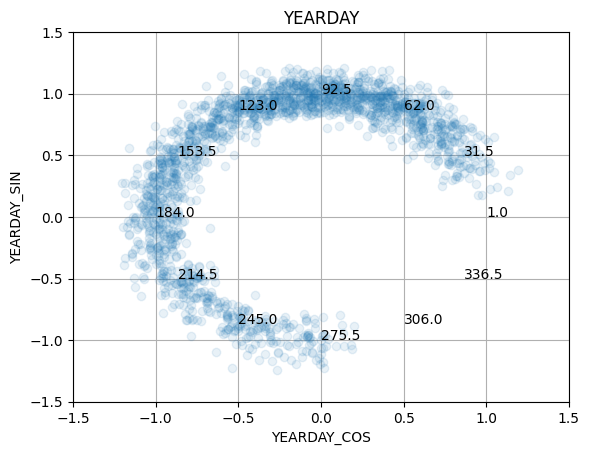

In [14]:
plt.clf()
plt.title("YEARDAY")
plt.xlabel("YEARDAY_COS")
plt.ylabel("YEARDAY_SIN")

# plt.rcParams["figure.figsize"] = (6, 6)

plt.grid(True)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
e1 = 0.1*np.random.normal(size=dx.shape[0])
e2 = 0.1*np.random.normal(size=dx.shape[0])
plt.plot(dx["YEARDAY_COS"]+e1, dx["YEARDAY_SIN"]+e2, "o", alpha=0.1)
for i in range(12):
    x = np.cos(2*np.pi*i*30.5/366)
    y = np.sin(2*np.pi*i*30.5/366)
    plt.text(x, y, str(30.5*i+1))
plt.show()

In [15]:
df.columns

Index(['Unnamed: 0', 'SLEEP_SUMMARY_ID', 'STUDY_PRTCPT_ID', 'STUDY_ID',
       'SLEEP_DATE', 'SLEEP_START_DATE', 'SLEEP_END_DATE', 'ASLEEP_VALUE',
       'INBED_VALUE', 'DEEP_MIN', 'DEEP_COUNT', 'LIGHT_MIN', 'LIGHT_COUNT',
       'REM_MIN', 'REM_COUNT', 'WAKE_MIN', 'WAKE_COUNT', 'ASLEEP_MIN',
       'ASLEEP_COUNT', 'AWAKE_COUNT', 'AWAKE_MIN', 'RESTLESS_COUNT',
       'RESTLESS_MIN', 'TYPE'],
      dtype='object')

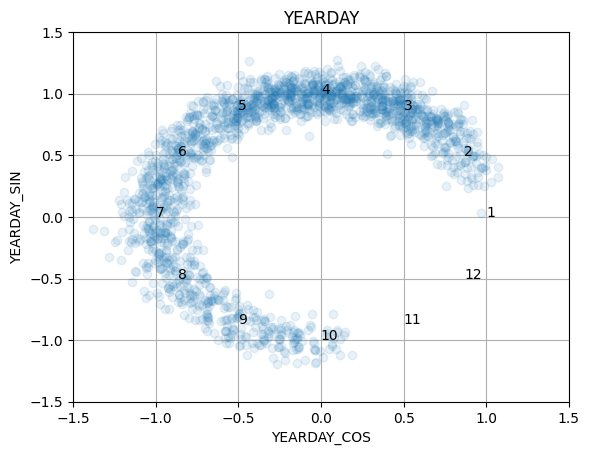

In [16]:
plt.clf()
plt.title("YEARDAY")
plt.xlabel("YEARDAY_COS")
plt.ylabel("YEARDAY_SIN")
plt.grid(True)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
e1 = 0.1*np.random.normal(size=dx.shape[0])
e2 = 0.1*np.random.normal(size=dx.shape[0])
plt.plot(dx["YEARDAY_COS"]+e1, dx["YEARDAY_SIN"]+e2, "o", alpha=0.1)
for i in range(12):
    x = np.cos(2*np.pi*i*30.5/366)
    y = np.sin(2*np.pi*i*30.5/366)
    # x = np.cos(2*np.pi*i*30.5)
    # y = np.sin(2*np.pi*i*30.5)
    
    plt.text(x, y, str(i+1))
plt.show()

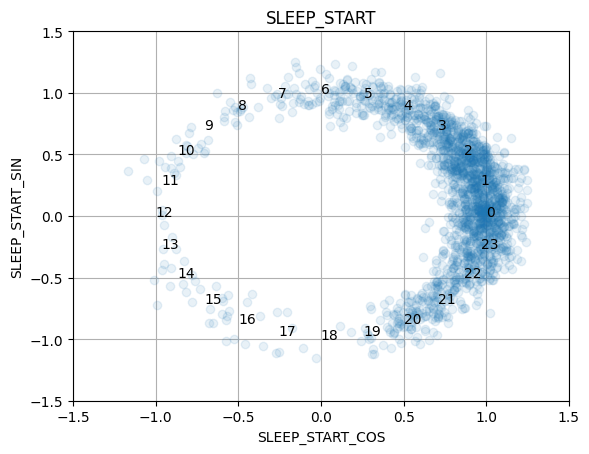

In [17]:
plt.clf()
plt.title("SLEEP_START")
plt.xlabel("SLEEP_START_COS")
plt.ylabel("SLEEP_START_SIN")
plt.grid(True)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
e1 = 0.1*np.random.normal(size=dx.shape[0])
e2 = 0.1*np.random.normal(size=dx.shape[0])
plt.plot(dx["SLEEP_START_COS"]+e1, dx["SLEEP_START_SIN"]+e2, "o", alpha=0.1)
for i in range(24):
    x = np.cos(2*np.pi*i/24)
    y = np.sin(2*np.pi*i/24)
    plt.text(x, y, str(i))
plt.show()

Standardize the sleep variables.

In [18]:
exclude = ["STUDY_PRTCPT_ID", "STUDYDAY", "YEARDAY_SIN", "YEARDAY_COS", "YEARDAY", "DAYOFWEEK"]
va = [x for x in dx.columns if x not in exclude]
dx[va] = dx[va] - dx[va].mean(0)
dx[va] = dx[va] / dx[va].std(0)
dx["STUDY_PRTCPT_ID"].value_counts()

STUDY_PRTCPT_ID
W7LX2I74    230
XKZF8SDS    189
T4CSRKVM    171
15LGWNGJ    152
XGJ8AFS8    142
RYFXBDFQ    112
CCD84K8N     81
MLYS5U85     76
N5F15GYZ     75
8MRVHIRR     74
UQUEK1XU     67
JEW6KQY3     52
KL8ZU5XC     49
VL61MMTY     48
SBTLFFUR     46
VZK8IVKE     41
3IJBZPI8     34
IS69SBYZ     29
1X8MBFBA     29
F1MALNM8     25
JU3R5P4M     23
RQ5P4ZR8     23
Y8PEMP7K     22
M5ENQMEA     12
YRTQ7TKL      5
D1C3M5J2      2
TQLY4RDR      1
Name: count, dtype: int64

<Axes: >

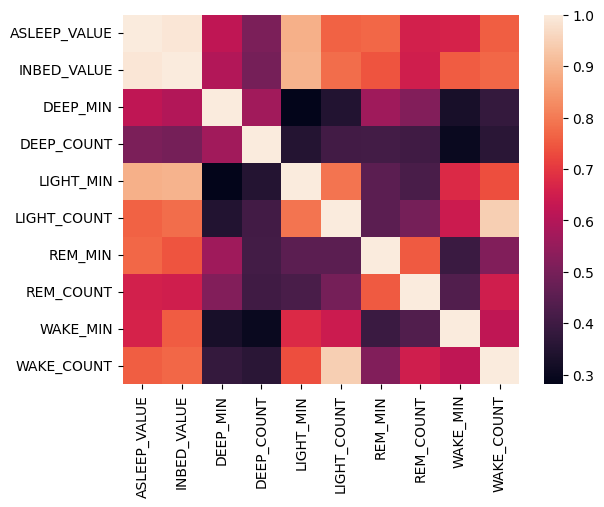

In [19]:
# Checking the heat map without rearranging according to the eigen values 
v = [x for x in va if not (x.endswith("_SIN") or x.endswith("_COS"))]
# print("v is %s" %v)
X = dx[v].copy()
X0 = X - X.mean(0)

sns.heatmap(X0.corr())

v is ['ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN', 'DEEP_COUNT', 'LIGHT_MIN', 'LIGHT_COUNT', 'REM_MIN', 'REM_COUNT', 'WAKE_MIN', 'WAKE_COUNT']
a is [4.06073728e-16 7.82420389e-04 2.83584683e-02 1.90556754e-01
 3.73137099e-01 4.19834653e-01 5.42227202e-01 7.33993311e-01
 1.27732883e+00 6.43378126e+00]
sorted values of eigenvalues for correlation matrix C is 
 [0 1 2 3 4 5 6 7 8 9]
jj is [1 0 9 5 4 6 7 8 2 3]


<Axes: >

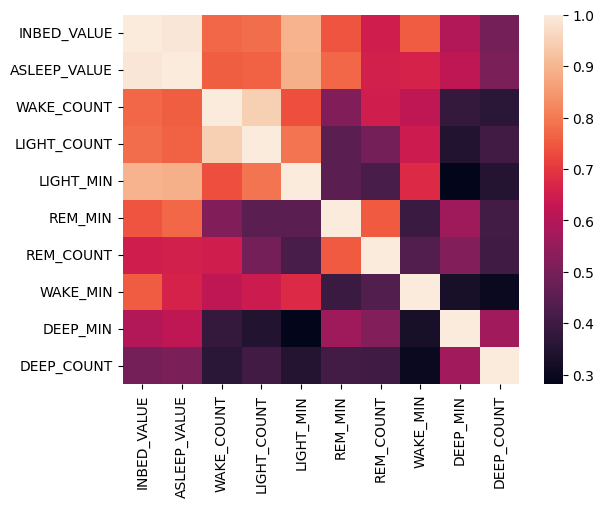

In [20]:
v = [x for x in va if not (x.endswith("_SIN") or x.endswith("_COS"))]
print("v is %s" %v)
X = dx[v].copy()
X0 = X - X.mean(0)
C = X0.corr()
a, b = eigh(C)
print("a is %s" %a)
# print ("b is %s" %b)
# print("C is %s" %C)
print("sorted values of eigenvalues for correlation matrix C is \n %s" %np.argsort(a))
ii = np.argmax(a)
# print("ii is %s" %ii)
jj = np.argsort(b[:, ii])
print ("jj is %s" %jj)
X0 = X0.iloc[:, jj]
sns.heatmap(X0.corr())

In [21]:
dx.describe()

ASLEEP_VALUE   INBED_VALUE      DEEP_MIN    DEEP_COUNT     LIGHT_MIN  \
count  1.810000e+03  1.810000e+03  1.810000e+03  1.810000e+03  1.810000e+03   
mean   1.216952e-16 -1.962825e-16  5.888476e-17 -3.533085e-17  1.256208e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -2.295753e+00 -2.170668e+00 -2.553592e+00 -2.391244e+00 -2.316280e+00   
25%   -6.277705e-01 -6.301359e-01 -6.875809e-01 -4.316220e-01 -6.922372e-01   
50%    3.064353e-02  2.133312e-02 -5.769327e-03  2.215852e-01 -8.976955e-02   
75%    6.693051e-01  6.421448e-01  6.401574e-01  8.747924e-01  6.043779e-01   
max    3.902118e+00  3.838175e+00  3.726252e+00  4.794036e+00  4.952622e+00   

        LIGHT_COUNT       REM_MIN     REM_COUNT      WAKE_MIN    WAKE_COUNT  \
count  1.810000e+03  1.810000e+03  1.810000e+03  1.810000e+03  1.810000e+03   
mean   1.727286e-16  7.458736e-17 -1.256208e-16 -7.851301e-17 -7.066171e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -2.268362e+00 -2.415119e+00 -2.010859e+00 -2.029565e+00 -2.260824e+00   
25%   -6.792502e-01 -7.070852e-01 -7.498921e-01 -7.021504e-01 -7.579258e-01   
50%   -4.360547e-02  4.017948e-02  6.688001e-03 -1.454928e-01 -5.657319e-02   
75%    5.920393e-01  6.273160e-01  5.110747e-01  5.824442e-01  6.447794e-01   
max    4.405908e+00  5.244344e+00  4.546169e+00  6.448760e+00  4.351929e+00   

           YEARDAY    DAYOFWEEK  SLEEP_START_SIN  SLEEP_START_COS  \
count  1810.000000  1810.000000     1.810000e+03     1.810000e+03   
mean    130.030939     3.013260     1.570260e-17     9.421561e-17   
std      65.508692     1.977161     1.000000e+00     1.000000e+00   
min      13.000000     0.000000    -2.228928e+00    -4.274548e+00   
25%      78.000000     1.000000    -6.762050e-01    -2.034010e-01   
50%     115.000000     3.000000     7.675023e-02     4.114163e-01   
75%     178.000000     5.000000     7.859031e-01     6.224955e-01   
max     277.000000     6.000000     1.568608e+00     6.744785e-01   

       YEARDAY_SIN  YEARDAY_COS     STUDYDAY  
count  1810.000000  1810.000000  1810.000000  
mean      0.445119    -0.241283    78.310497  
std       0.638879     0.579566    63.472377  
min      -0.999963    -1.000000     0.000000  
25%       0.085731    -0.794658    25.000000  
50%       0.745438    -0.295927    61.000000  
75%       0.949990     0.229688   120.750000  
max       0.999963     0.975200   264.000000

Plot histograms of each sleep variable.

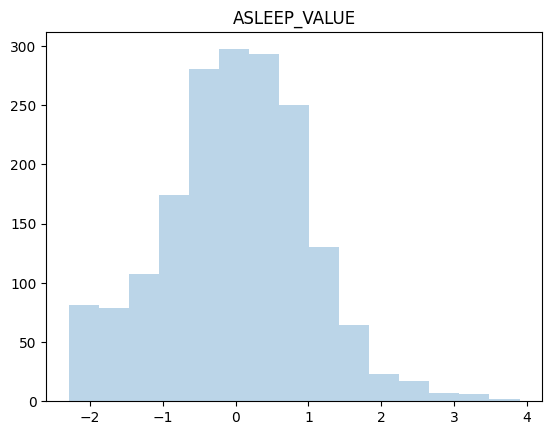

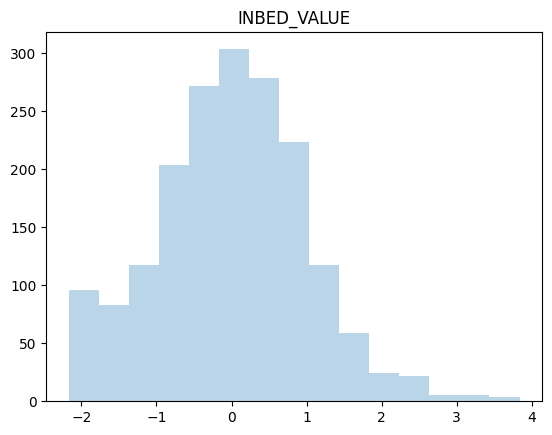

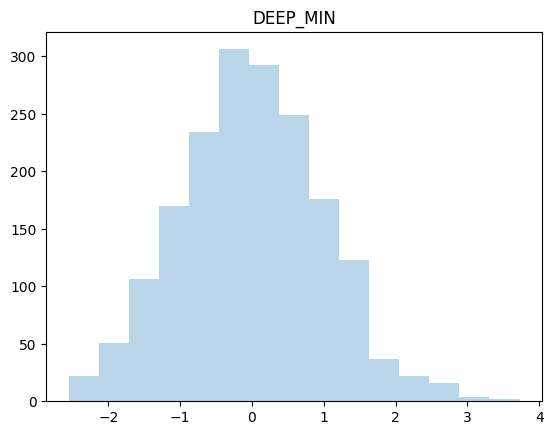

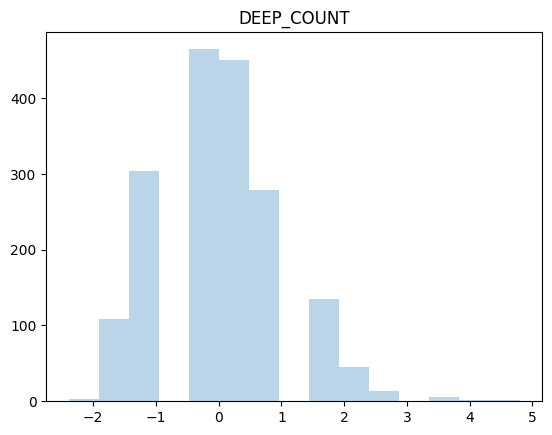

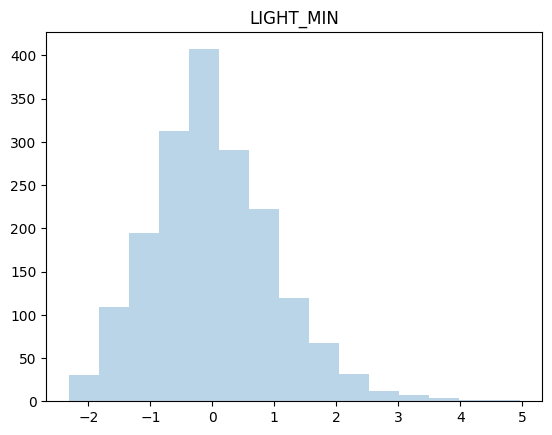

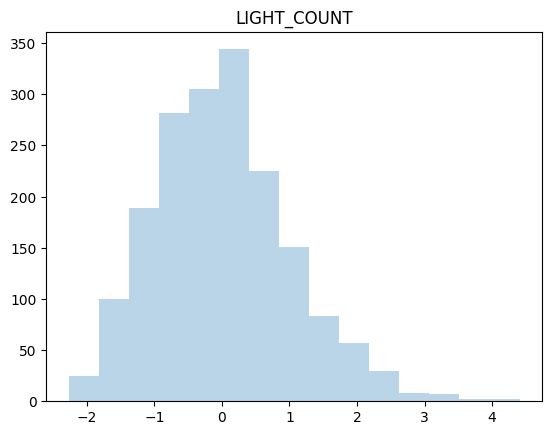

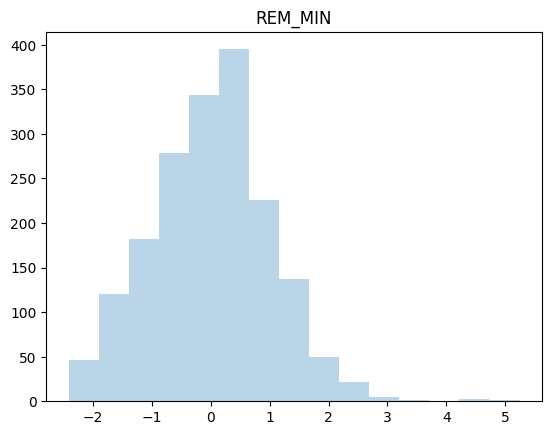

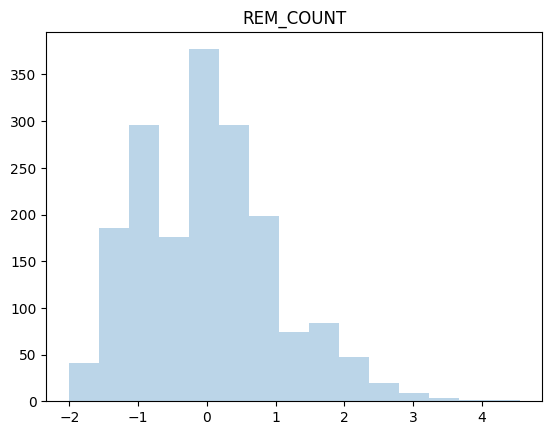

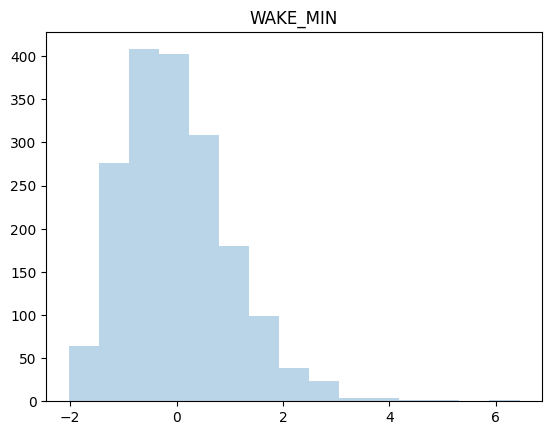

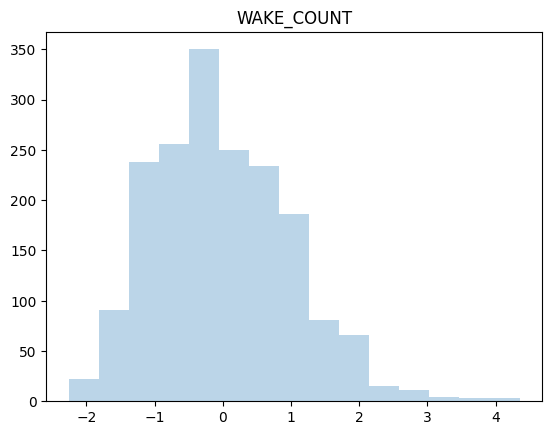

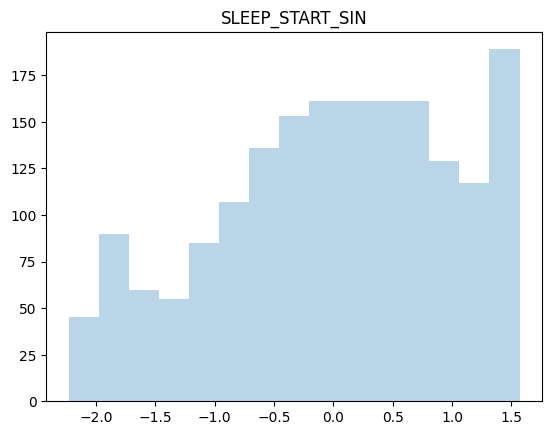

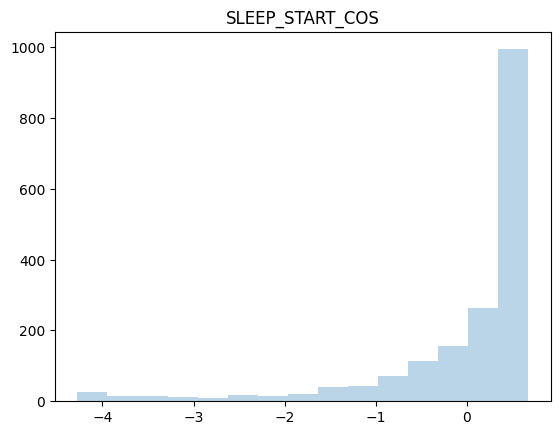

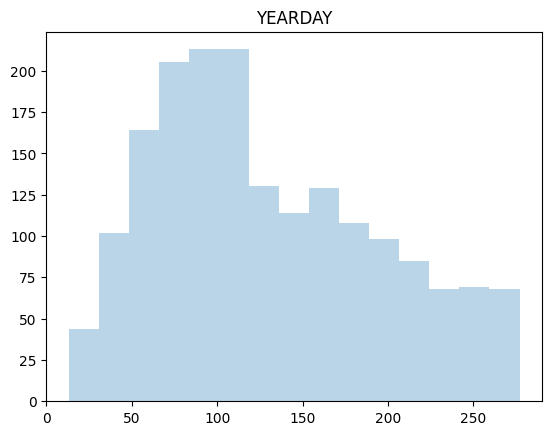

In [22]:
for v in va + ["YEARDAY"]:
    plt.hist(dx[v], bins=15, alpha=0.3)
    plt.title(v)
    plt.show()

# PCA/biplots

In [23]:
def plot_eigs(eigs): # Plot all the logarithms of all the eigenvalues greater than 1e-10 in 
    jj = np.arange(1, len(eigs) + 1)
    ii = np.flatnonzero(eigs >= 1e-10) # np.flatnonzero returns indices of the non-zero elements 
    plt.clf()
    plt.grid(True)
    plt.plot(np.log(jj[ii]), np.log(eigs[ii]), "-o")
    plt.ylabel("Log eigenvalue", size=15)
    plt.xlabel("Log position", size=15)
    plt.show()

In [24]:
# help(np.flatnonzero)
# Notes-- The profile plot shows the correlations between each PC and the original variables. 


In [25]:
def varimax(X, eps=1e-05, maxiter=1000):
    G = X.copy()
    m, p = G.shape
    Q = np.eye(p)
    if p < 2: 
        return G, Q
    d = 0.0
    for i in range(maxiter):
        z = np.dot(G, Q)
        cs = (z**2).sum(0)
        B = np.dot(G.T, z**3 - z * (cs / m))
        u, s, vt = np.linalg.svd(B, 0)
        Q = np.dot(u, vt)
        dlast = d
        d = s.sum()
        if d < dlast * (1 + eps): 
            break
            
    G = np.dot(G, Q)
    return G, Q

In [26]:
# help(np.linalg.svd)

In [27]:
def ellipse_plot(U, idx, j0, j1):
    r2 = chi2(2).ppf(0.95)
    rr = np.sqrt(r2)
    dx = pd.DataFrame({"u0": U[:, 0], "u1": U[:, 1], "id": idx})
    plt.clf()
    plt.figure(figsize=(10, 10))
    plt.grid(True)
    plt.plot(dx["u0"], dx["u1"], "o", color="black", alpha=0.05)
    for (ky,dg) in dx.groupby("id"):
        if dg.shape[0] > 10:
            m0, m1 = dg["u0"].mean(), dg["u1"].mean()
            C = np.cov(dg["u0"], dg["u1"])
            a, b = eigh(C)
            plt.plot([m0], [m1], "o", color="blue", ms=8, alpha=0.2)
            ang = np.arctan2(b[1, 1], b[0, 1])*360/(2*np.pi)
            E = Ellipse(xy=[m0,m1], width=rr*np.sqrt(a[1]), height=rr*np.sqrt(a[0]), fc="none", ec="black", angle=ang)
            plt.gca().add_artist(E)
    plt.xlabel("Component %d" % j0, size=17)
    plt.ylabel("Component %d" % j1, size=17)
    plt.show()

In [28]:
# va

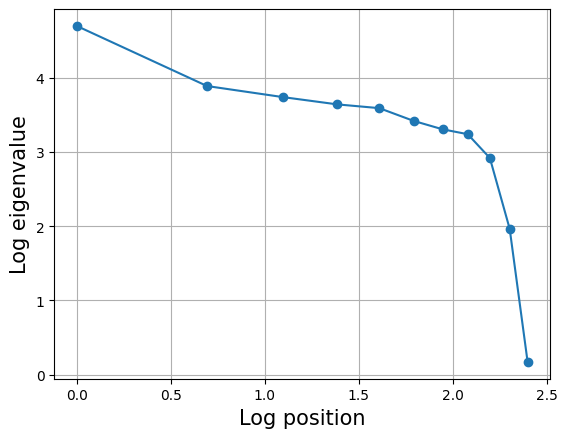

<Figure size 640x480 with 0 Axes>

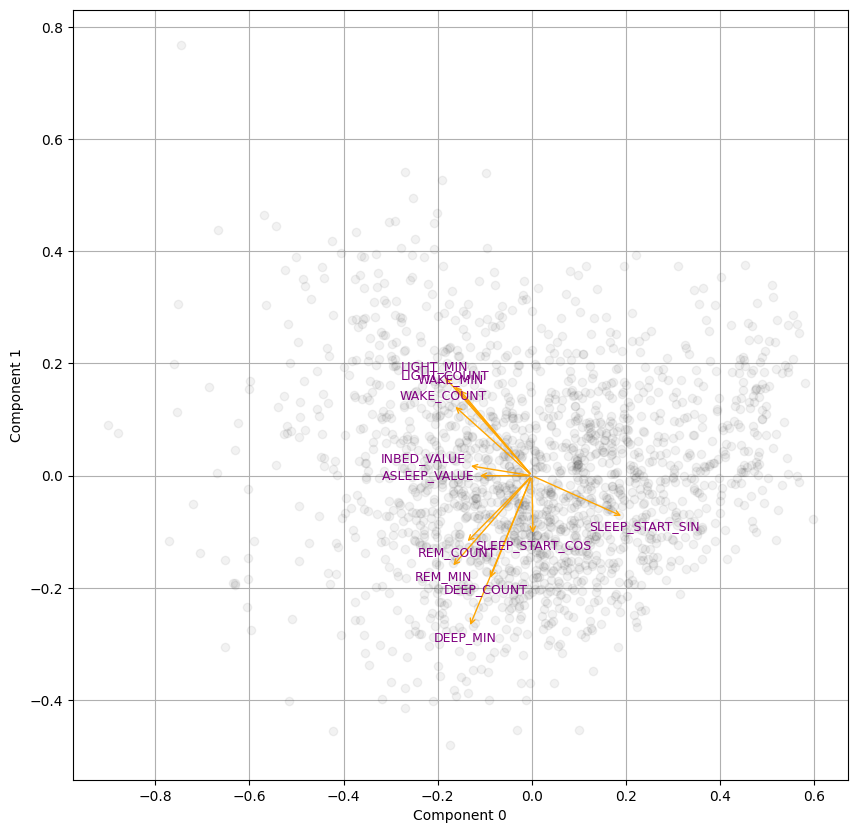

<Figure size 640x480 with 0 Axes>

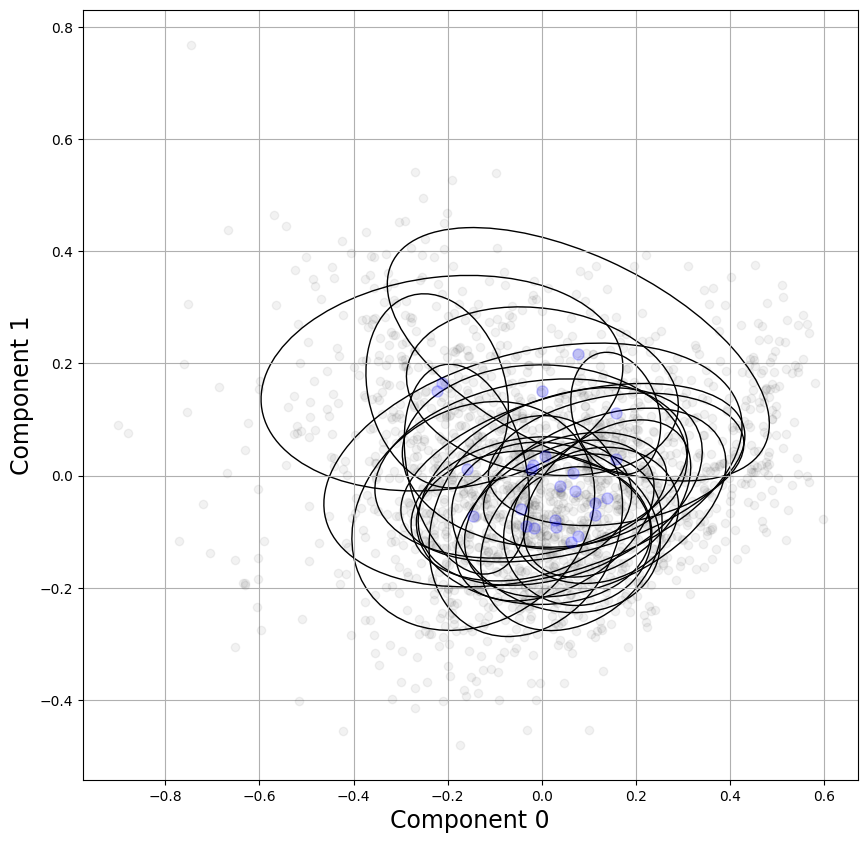

<Figure size 640x480 with 0 Axes>

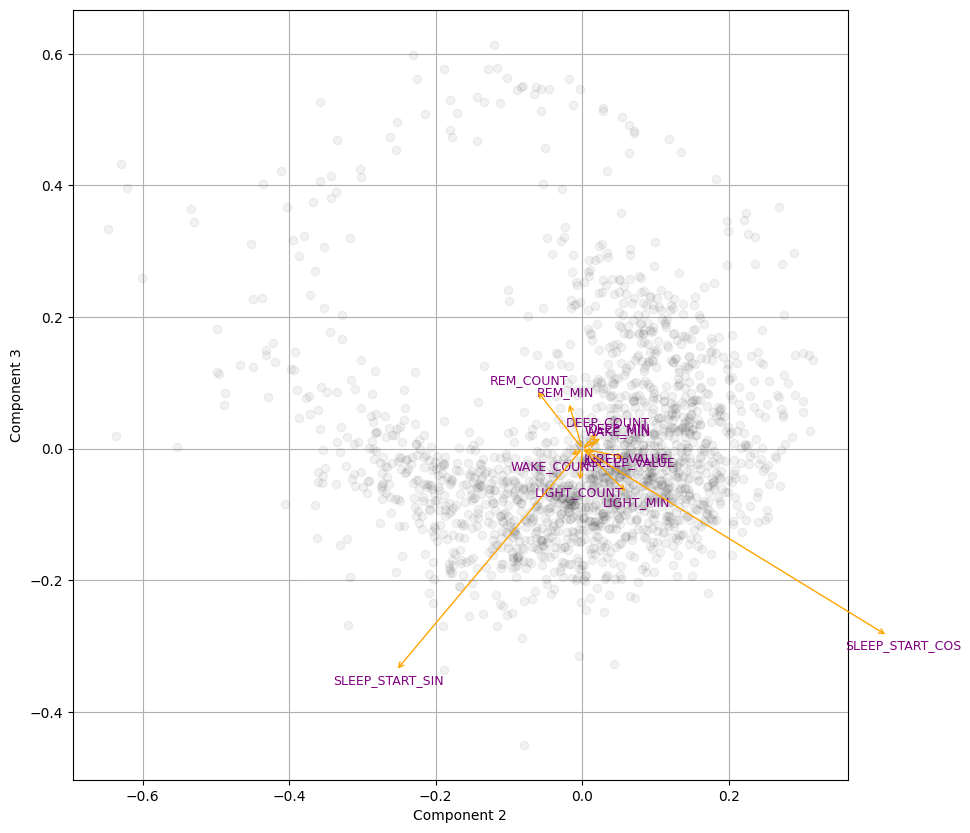

<Figure size 640x480 with 0 Axes>

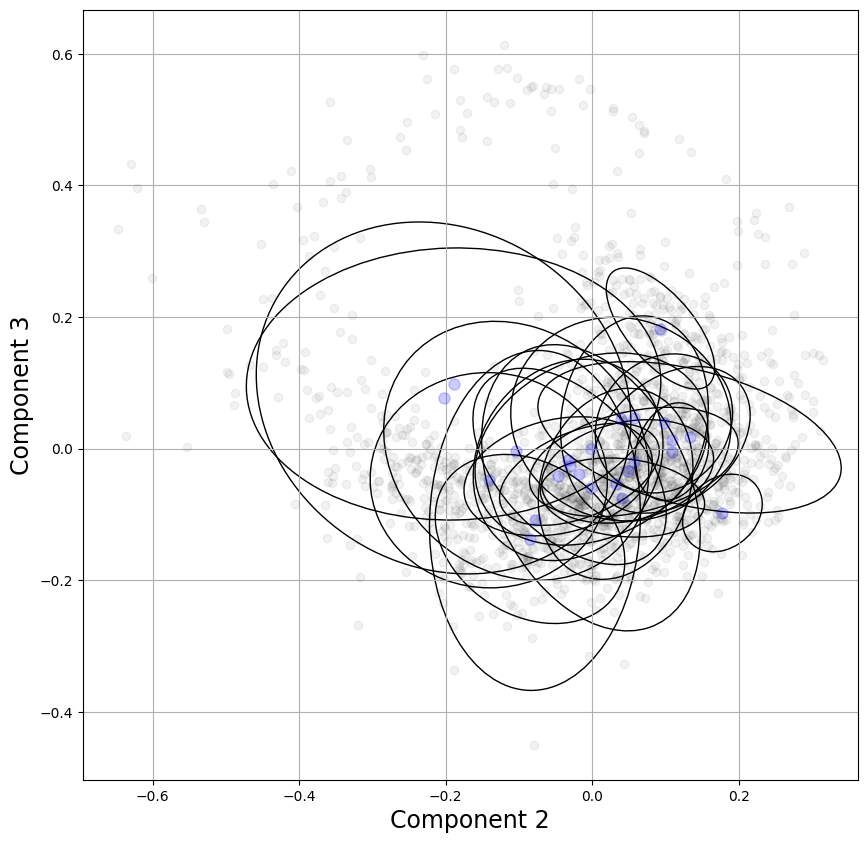

<Figure size 640x480 with 0 Axes>

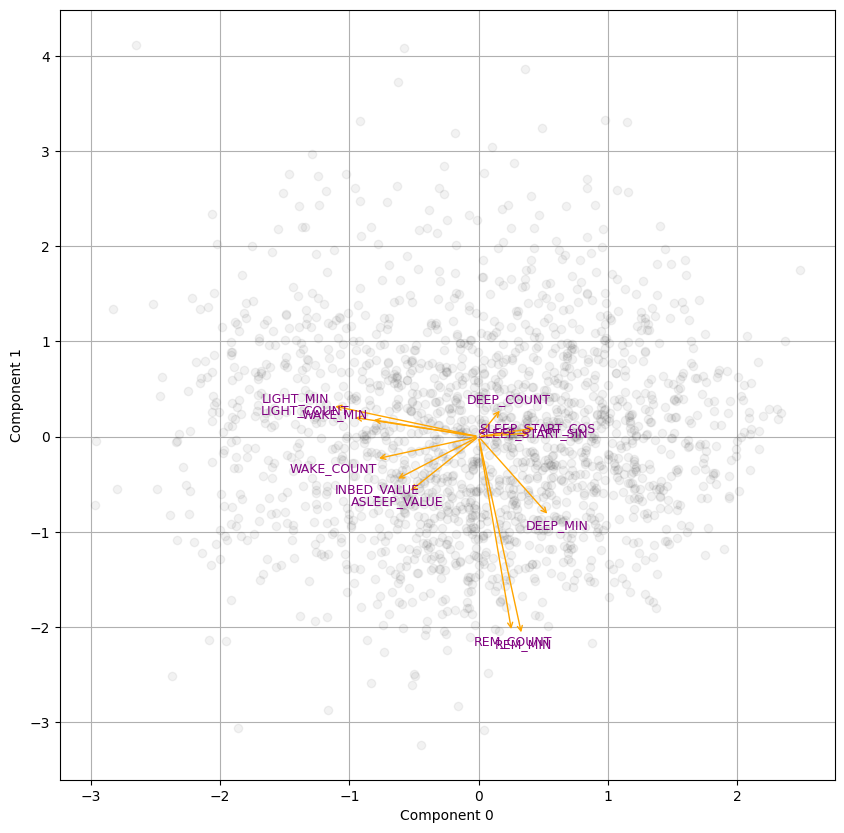

<Figure size 640x480 with 0 Axes>

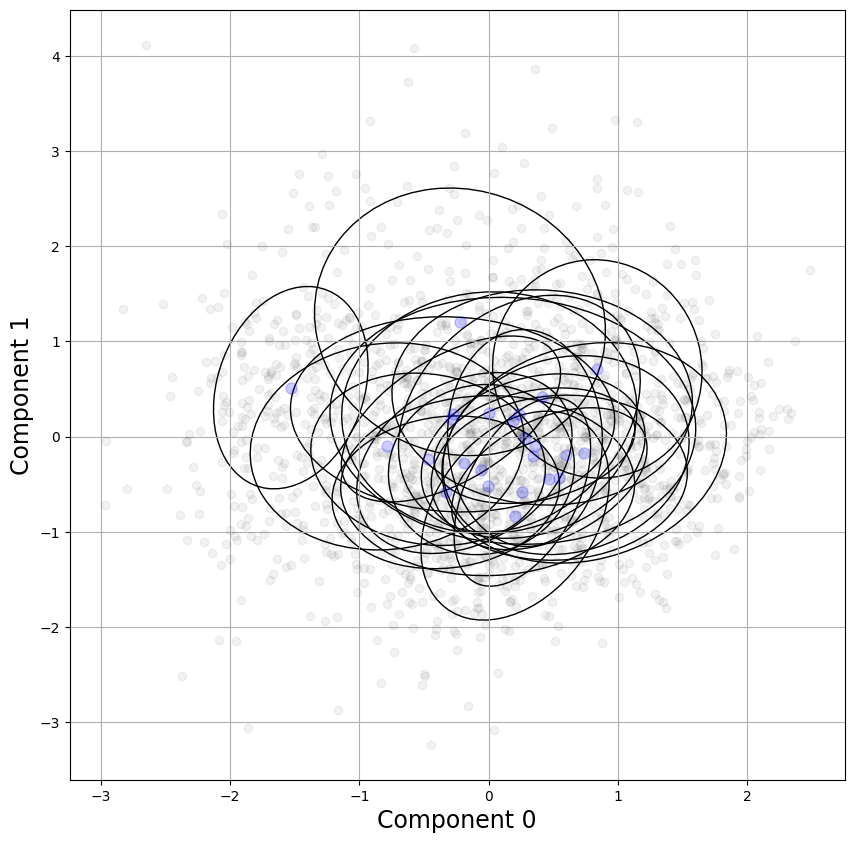

<Figure size 640x480 with 0 Axes>

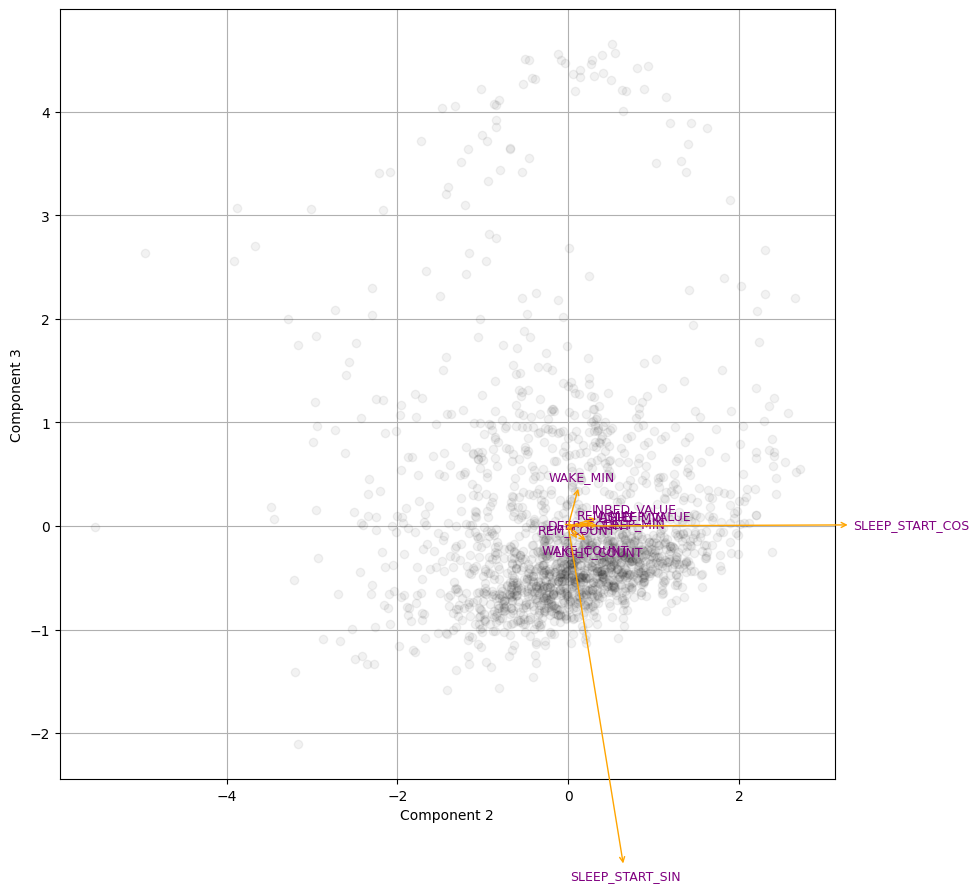

<Figure size 640x480 with 0 Axes>

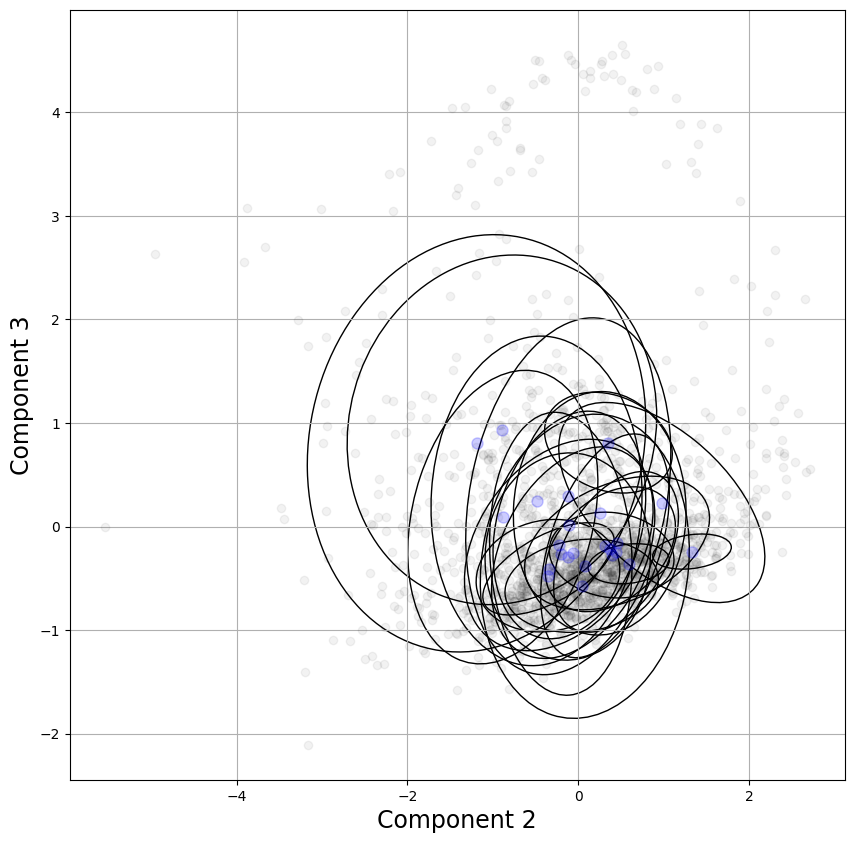

In [29]:
def biplot(dx, va, j=0, k=1, d=5, rotate=False, scree=False, ellipses=False):
    assert d > max(j, k)
    dx = dx.copy()
    X = np.asarray(dx[va])
    n, p = X.shape
    X -= X.mean()
    X -= X.mean(0)
    u, s, vt = np.linalg.svd(X, 0)
    v = vt.T
    if scree:
        plot_eigs(s)
    uu = u[:, 0:d]
    vv = v[:, 0:d]
    ss = s[0:d]
    if rotate:
        uu, Ru = varimax(uu)
        uu *= np.sqrt(n)
        vv, Rv = varimax(vv)
        vv *= np.sqrt(p)
        B = np.dot(Ru.T * ss, Rv) / np.sqrt(n*p)
    else:
        uu *= (ss**0.5)
        vv *= (ss**0.5)
        B = np.eye(d)
        
    ff = np.sqrt(X.shape[0] / X.shape[1]) # May need to adjust this
    v /= ff
    plt.clf()
    plt.figure(figsize=(10, 10))
    plt.grid(True)
    plt.plot(uu[:, j], uu[:, k], "o", color="black", alpha=0.05)
    for i in range(v.shape[0]):
        plt.annotate(va[i], xy=(0, 0), xytext=(vv[i, j], vv[i, k]), 
                     arrowprops=dict(color='orange', arrowstyle="<-"), color="purple", size=9)
    plt.xlabel("Component %d" % j)
    plt.ylabel("Component %d" % k)
    plt.show()
    
    if ellipses:
        ellipse_plot(uu[:, [j, k]], dx["STUDY_PRTCPT_ID"], j,k)
        
biplot(dx, va, 0, 1, d=5, rotate=False, scree=True, ellipses=True)
biplot(dx, va, 2, 3, d=5, rotate=False, ellipses=True)
biplot(dx, va, 0, 1, d=5, rotate=True, ellipses=True)
biplot(dx, va, 2, 3, d=5, rotate=True, ellipses=True)

In [30]:
# Check variables 
dx.columns


Index(['STUDY_PRTCPT_ID', 'ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN',
       'DEEP_COUNT', 'LIGHT_MIN', 'LIGHT_COUNT', 'REM_MIN', 'REM_COUNT',
       'WAKE_MIN', 'WAKE_COUNT', 'YEARDAY', 'DAYOFWEEK', 'SLEEP_START_SIN',
       'SLEEP_START_COS', 'YEARDAY_SIN', 'YEARDAY_COS', 'STUDYDAY'],
      dtype='object')

# MANOVA

Use multivariate analysis of variance (MANOVA) to understand the between-subject and within-subject differences.

In [31]:
def manova1(dx, va, grp):
    """
    Run MANOVA on the data in dx[va], which have been centered.  The groups are
    defined by the column dx[grp].
    
    Returns:
    - H : Scaled estimate of Cov E[X|g]
    - E : Scaled estimate of E Cov[X|g]
    - ee : eigenvalues of E^-1 H
    - B : eigenvectors of E^-1 H
    - (pillai, trace, lawley, roy) : fit statistics
    """
    dg = dx.groupby(grp)[va]
    X = dx[va].values
    w = dg.size()
    M = dg.mean()
    assert all(w.index == M.index)
    w = w.values
    M = M.values
    Mw = np.sqrt(w)[:, None] * M
    H = np.dot(Mw.T, Mw)
    E = np.dot(X.T, X) - H
    ee, B = eigh(H, E)
    if ee.min() < 0:
        raise ValueError("Negative eigenvalue in MANOVA")
    ii = np.argsort(-ee)
    ee = ee[ii]
    B = B[:, ii]
    pillai = np.sum(ee / (1 + ee))
    lawley = np.sum(ee)
    wilks = np.prod(1 / (1 + ee))
    roy = ee[0] / (1 + ee[0])
    return H, E, ee, B, (pillai, lawley, wilks, roy)

In [32]:
def manova(dx, va, grp, nrep=1000, center=True):
    """
    Run MANOVA on the data in X, using randomization to calibrate the statistics.
    
    Returns:
    - H : Scaled estimate of Cov E[X|g]
    - E : Scaled estimate of E Cov[X|g]
    - ee : eigenvalues of E^-1 H
    - B : eigenvectors of E^-1 H
    - (pillai, trace, lawley, roy) : fit statistics
    - stats0 : each row is a randomized realization of the fit statistics
    """
    dx = dx.copy()
    if center:
        dx[va] = dx[va] - dx[va].mean(0)
    X = dx[va].values
    a, _ = np.linalg.eigh(np.cov(X.T))
    if a.min() <= 1e-8:
        raise ValueError("The marginal covariance matrix is singular")
    n = dx.shape[0]
    H, E, ee, B, stats = manova1(dx, va, grp)
    stats0 = np.empty((nrep, 4))
    for i in range(nrep):
        dx[grp] = dx[grp].sample(frac=1).values
        _, _, _, _, s = manova1(dx, va, grp)
        stats0[i, :] = s
        
    return X, H, E, ee, B, stats, stats0

Transform the MANOVA summary statistics to make them more interpretable.

In [33]:
def xstat_manova(stats, stats0, p):
    stats = np.copy(stats)
    stats0 = np.copy(stats0)
    # Pillai becomes the mean PVE
    stats[0] /= p
    stats0[:, 0] /= p
    # Lawley becomes the mean SNR
    stats[1] /= p
    stats0[:, 1] /= p
    # Wilks becomes the geometric mean of 1 - PVE
    stats[2] = np.power(stats[2], 1/p)
    stats0[:, 2] = np.power(stats0[:, 2], 1/p)
    # Not sure what to do with this...
    stats[3] = np.power(stats[3], 1/p)
    stats0[:, 3] = np.power(stats0[:, 3], 1/p)
    return stats, stats0

Run the MANOVA to assess inter-subject differences.  ASLEEP_VALUE is redundant so drop it here.

In [34]:
va1 = [x for x in va if x != "ASLEEP_VALUE"]
X0, H, E, ee, B, stats, stats0 = manova(dx, va1, "STUDY_PRTCPT_ID")
statsx, stats0x = xstat_manova(stats, stats0, len(va))

Plot the summary statistics.

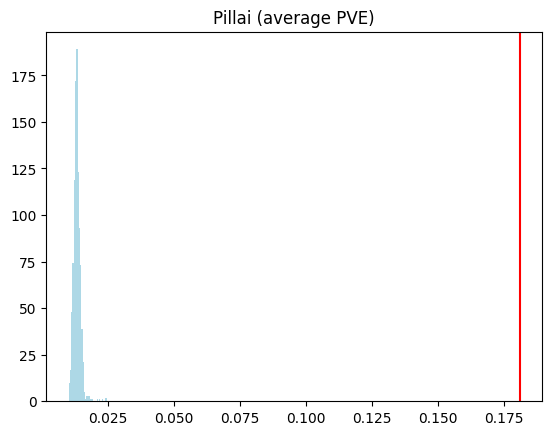

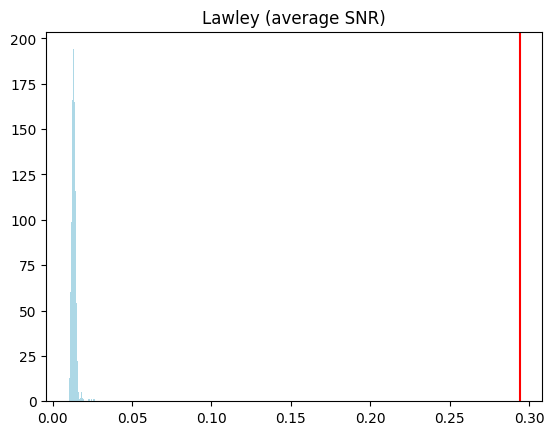

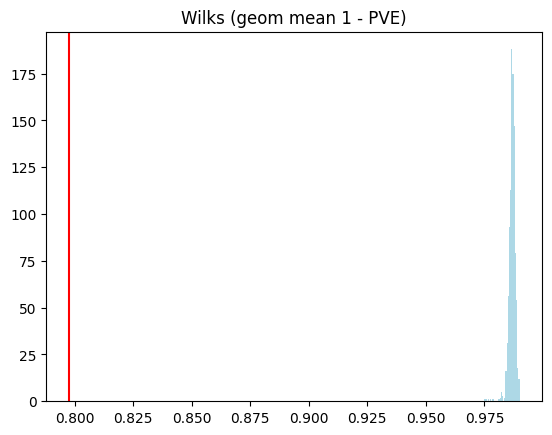

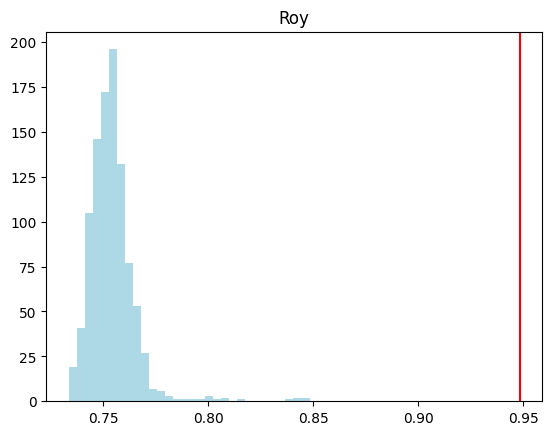

In [35]:
for (k, ti) in enumerate(["Pillai (average PVE)", "Lawley (average SNR)", "Wilks (geom mean 1 - PVE)", "Roy"]):
    plt.hist(stats0x[:, k], bins=30, color="lightblue")
    plt.axvline(statsx[k], color="red")
    plt.title(ti)
    plt.show()

Generate biplots to show how the MANOVA factors relate to the observed variables

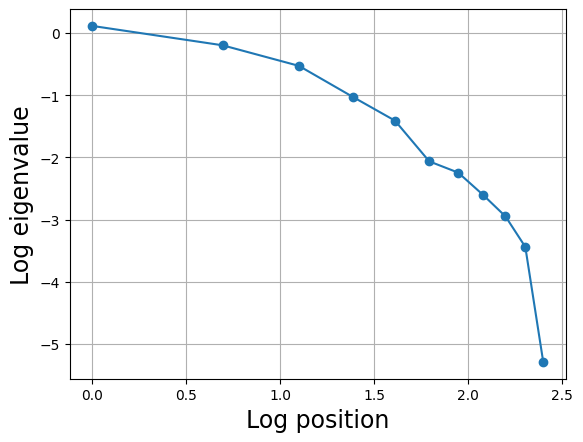

<Figure size 640x480 with 0 Axes>

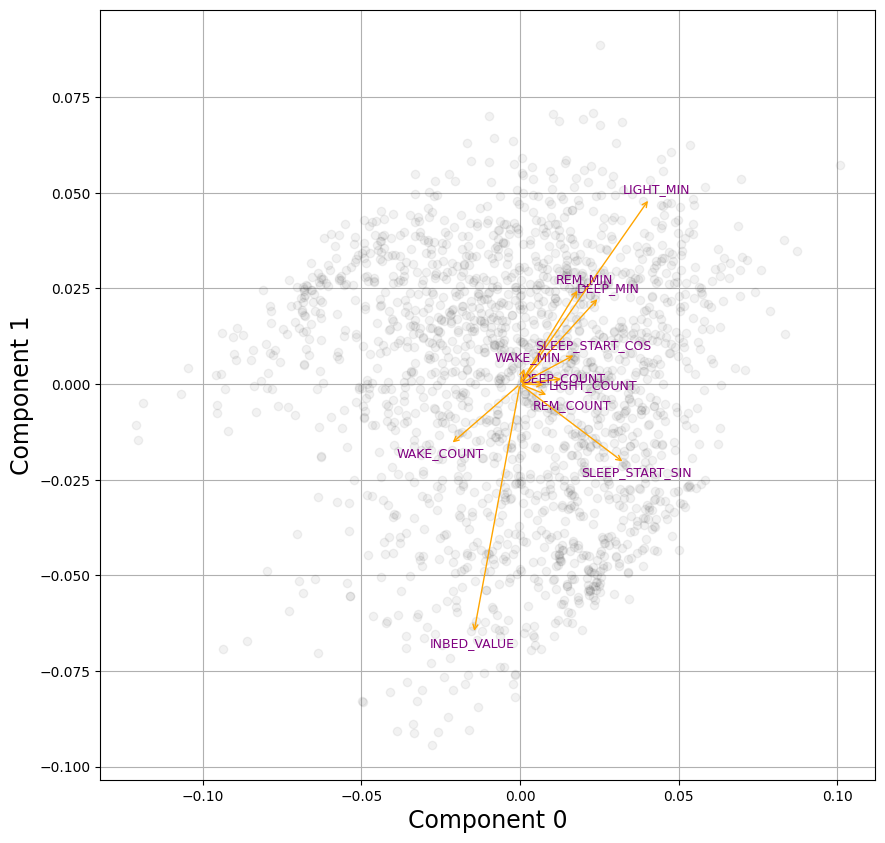

<Figure size 640x480 with 0 Axes>

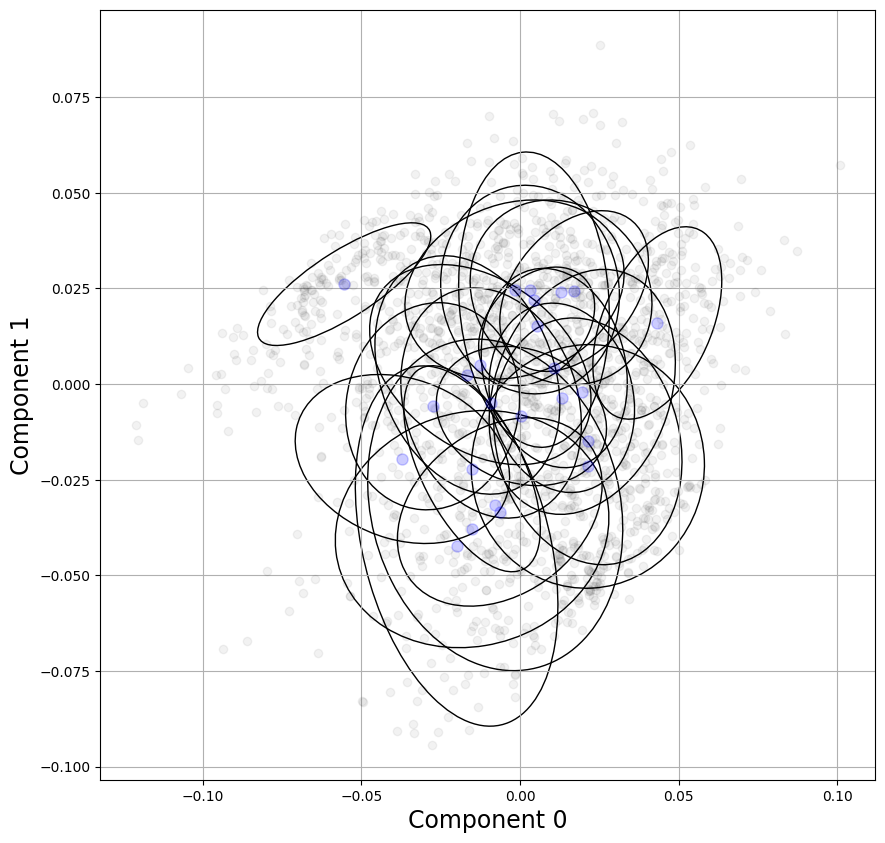

<Figure size 640x480 with 0 Axes>

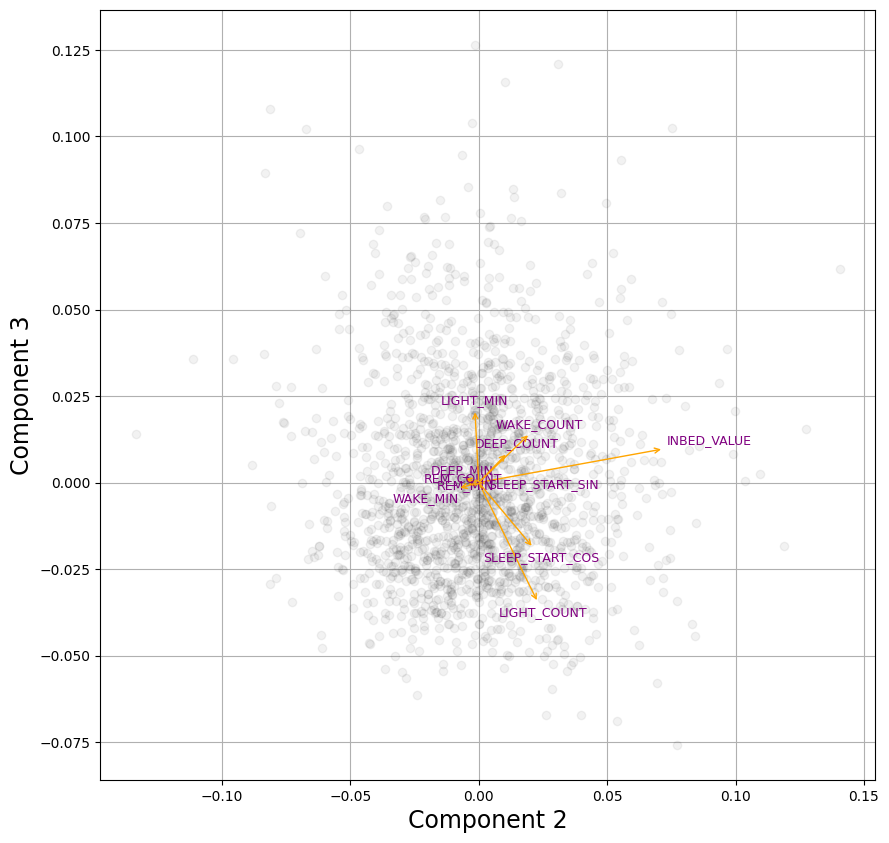

<Figure size 640x480 with 0 Axes>

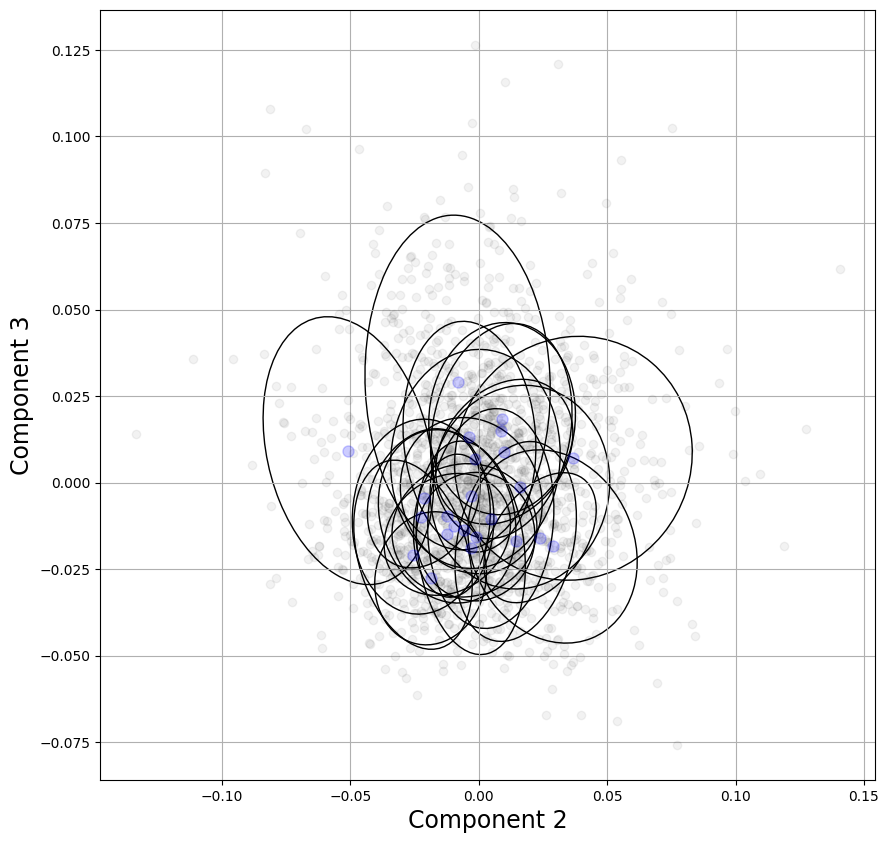

<Figure size 640x480 with 0 Axes>

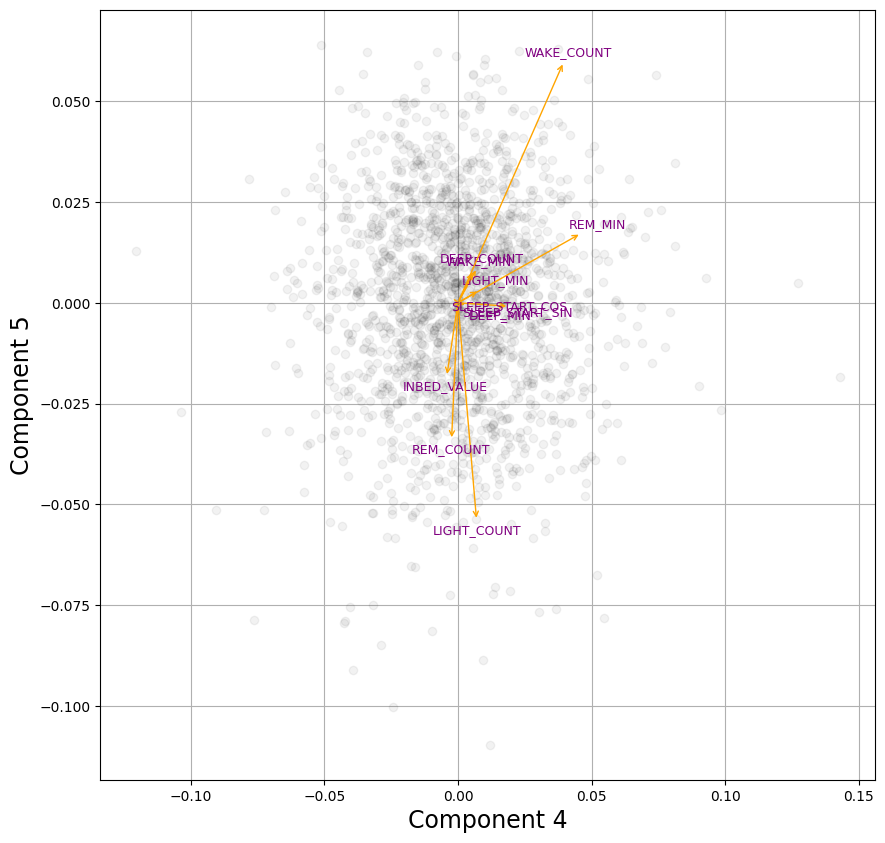

<Figure size 640x480 with 0 Axes>

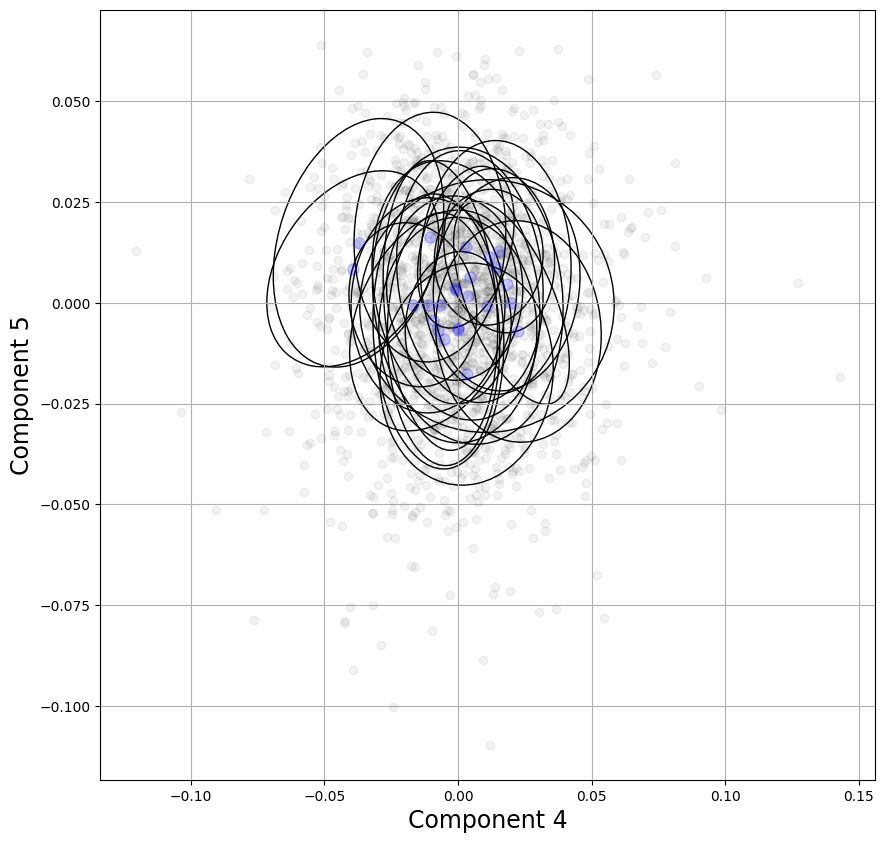

In [36]:
def biplot(j0, j1, X0, B, ee, va, scree=False, ellipses=True):
    scores = np.dot(X0, B[:, [j0, j1]])
    if scree:
        plt.clf()
        plt.grid(True)
        jj = np.arange(1, len(ee)+1)
        plt.plot(np.log(jj), np.log(ee), "-o")
        plt.xlabel("Log position", size=17)
        plt.ylabel("Log eigenvalue", size=17)
        plt.show()
    plt.clf()
    plt.figure(figsize=(10,10))
    plt.grid(True)
    plt.plot(scores[:, 0], scores[:, 1], "o", color="black", alpha=0.05)
    for i in range(B.shape[0]):
        plt.annotate(va[i], xy=(0, 0), xytext=(B[i, j0], B[i, j1]), 
                     arrowprops=dict(color='orange', arrowstyle="<-"), color="purple", size=9)
    plt.xlabel("Component %d" % j0, size=17)
    plt.ylabel("Component %d" % j1, size=17)
    plt.show()

    if ellipses:
        ellipse_plot(scores, dx["STUDY_PRTCPT_ID"], j0, j1)
    
biplot(0, 1, X0, B, ee, va1, scree=True, ellipses=True)
biplot(2, 3, X0, B, ee, va1, ellipses=True)
biplot(4, 5, X0, B, ee, va1, ellipses=True)

# Dimension reduction regression

Use sliced inverse regression to understand the possible roles of day of week, and seasonality

In [37]:
def sir(dx, xv, yv):
    dx = dx.copy()
    dx[xv] = dx[xv] - dx[xv].mean(0)
    C = dx[xv].cov()
    a,_ = eigh(C)
    if a.min() < 1e-10:
        raise ValueError("Marginal covariance of predictors is singular")
    mn, wt = [], []
    for (ky,dg) in dx.groupby(yv):
        mn.append(dg[xv].mean(0))
        wt.append(dg.shape[0])
    M = np.stack(mn)
    wt = np.asarray(wt)
    wt = wt / wt.sum()
    Mw = np.sqrt(wt)[:, None] * M
    H = np.dot(Mw.T, Mw)    
    a, b = eigh(H, C)
    ii = np.argsort(-a)
    a = a[ii]
    b = b[:, ii]
    b = pd.DataFrame(b, columns=["B%d" % j for j in range(len(xv))], index=xv)
    return b, a

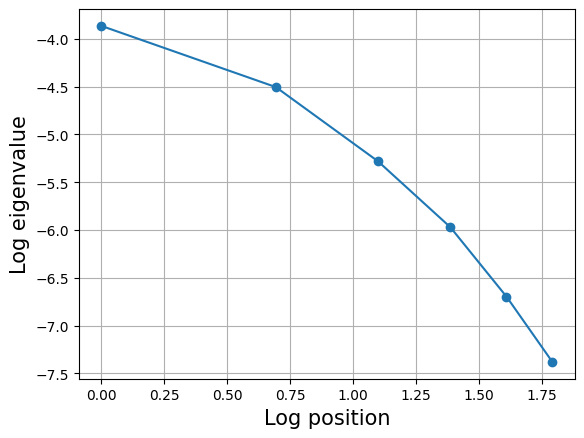

B0        B1        B2        B3
DEEP_MIN        -0.269828 -0.329036  0.148771 -0.851618
DEEP_COUNT      -0.039467 -0.065625 -0.665867  0.519352
LIGHT_MIN       -0.794248  0.552368  0.185711 -0.911046
LIGHT_COUNT      0.315917 -1.672467  0.202504  0.941060
REM_MIN         -0.243473  0.267806  0.414356  0.518458
REM_COUNT       -0.242282 -0.168493 -0.377468  0.515324
WAKE_MIN         0.106245 -0.294386 -0.224968 -0.209726
WAKE_COUNT       0.139769  1.543406  0.653347 -0.294179
SLEEP_START_SIN -0.789457 -0.276227 -0.148133 -0.045698
SLEEP_START_COS  0.280264 -0.724158  0.235147  0.123856

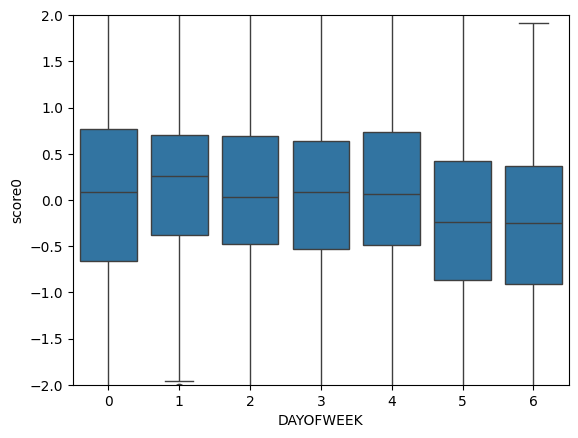

In [38]:
va2 = [x for x in va1 if x != "INBED_VALUE"]

dirs, eigs = sir(dx, va2, "DAYOFWEEK")
plot_eigs(eigs)

dirs.iloc[:, 0:4]
scores = np.dot(dx[va2], dirs.iloc[:, 0:3])

dp = pd.DataFrame({"DAYOFWEEK": dx["DAYOFWEEK"], "score0": scores[:, 0]})
sns.boxplot(dp, x="DAYOFWEEK", y="score0")
plt.ylim(-2, 2)
dirs.iloc[:, 0:4]

C:\Users\rajnishk\AppData\Local\Temp\ipykernel_23596\3073359268.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (ky,dg) in dx.groupby(yv):


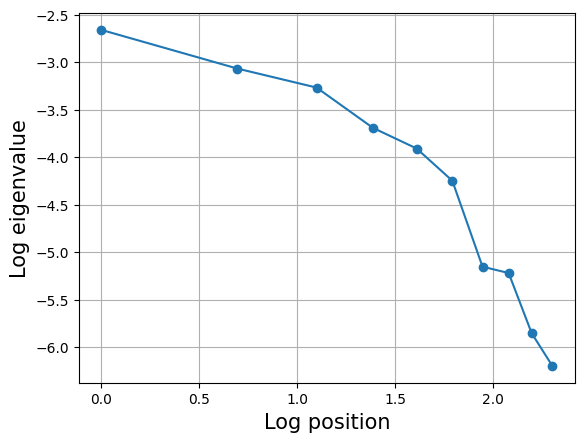

B0        B1        B2        B3
DEEP_MIN         0.084167 -0.161764 -0.045112 -0.596982
DEEP_COUNT      -0.154772  0.188886  0.004901  0.493160
LIGHT_MIN       -0.751683  0.623642  0.299493 -0.983167
LIGHT_COUNT      0.995185 -1.122676 -0.641698  1.638108
REM_MIN         -0.659126  0.278777 -0.208813  0.458329
REM_COUNT        0.753576 -1.177803 -0.197125 -0.218326
WAKE_MIN         0.322364  0.023619 -0.882444  0.262782
WAKE_COUNT      -0.905359  1.495596  0.879928 -0.662660
SLEEP_START_SIN  0.591800  0.545227  0.143610  0.197652
SLEEP_START_COS -0.034474 -0.336437  0.684882  0.450425

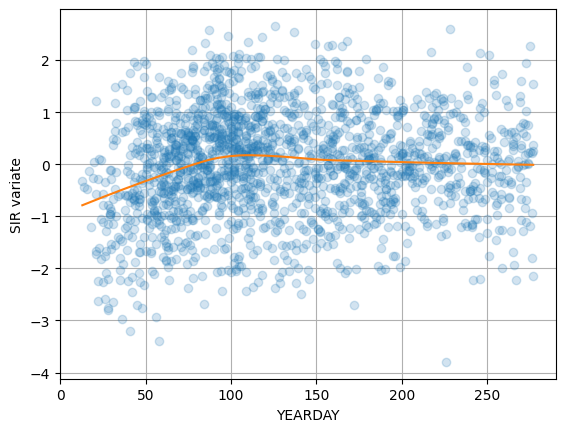

In [39]:
dx["YEARDAYu"] = pd.qcut(dx["YEARDAY"], 20)

dirs, eigs = sir(dx, va2, "YEARDAYu")
plot_eigs(eigs)

scores = np.dot(dx[va2], dirs.iloc[:, 0:3])

xy = lowess(scores[:, 0], dx["YEARDAY"])

plt.clf()
plt.grid(True)
plt.plot(dx["YEARDAY"], scores[:, 0], "o", alpha=0.2)
plt.plot(xy[:, 0], xy[:, 1], "-")
plt.ylabel("SIR variate")
plt.xlabel("YEARDAY")
dirs.iloc[:, 0:4]

In [40]:
np.shape(scores)

(1810, 3)

# UMAP

This is a very popular modern method but I'm not sure whether it will be useful for us.  It is worth a try.

In [41]:
import umap
import umap.umap_ as umap

um = umap.UMAP(random_state=123)
emb = um.fit_transform(dx[va1])
emb -= emb.mean(0)
emb /= emb.std(0)

C:\Users\rajnishk\AppData\Local\anaconda3\envs\SWG_analysis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\rajnishk\AppData\Local\anaconda3\envs\SWG_analysis\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Color the points by person

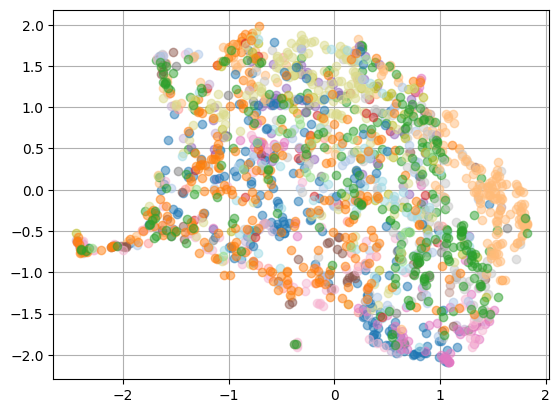

In [42]:
tab20 = matplotlib.colormaps["tab20"].colors
plt.clf()
plt.grid(True)
dp = pd.DataFrame({"id": dx["STUDY_PRTCPT_ID"], "emb0": emb[:, 0], "emb1": emb[:, 1]})
for j,(ky,dg) in enumerate(dp.groupby("id")):
    plt.plot(dg["emb0"], dg["emb1"], "o", alpha=0.5, color=tab20[j % 20])

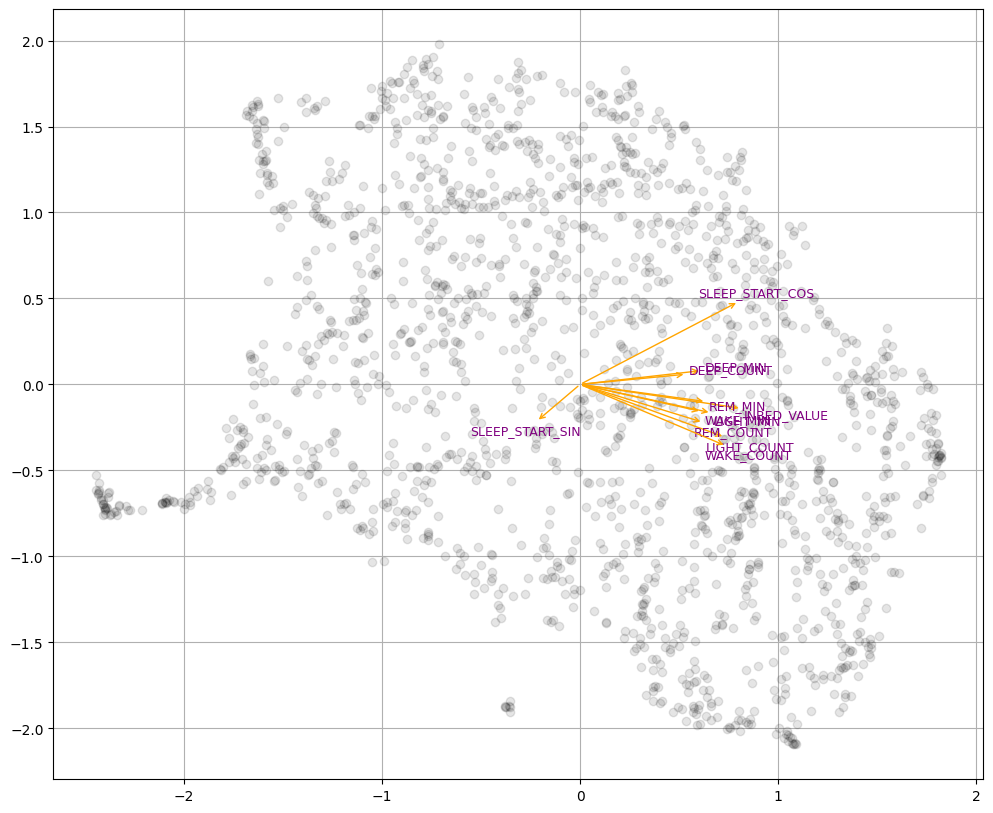

In [43]:
plt.clf
plt.figure(figsize=(12, 10))
plt.grid(True)
plt.plot(emb[:, 0], emb[:, 1], "o", color="black", alpha=0.1)
for v in va1:
    cc = np.linalg.lstsq(emb, dx[v], rcond=None)[0]
    plt.annotate(v, xy=(0, 0), xytext=cc, 
                 arrowprops=dict(color='orange', arrowstyle="<-"), color="purple", size=9)
plt.show()

<Figure size 640x480 with 0 Axes>

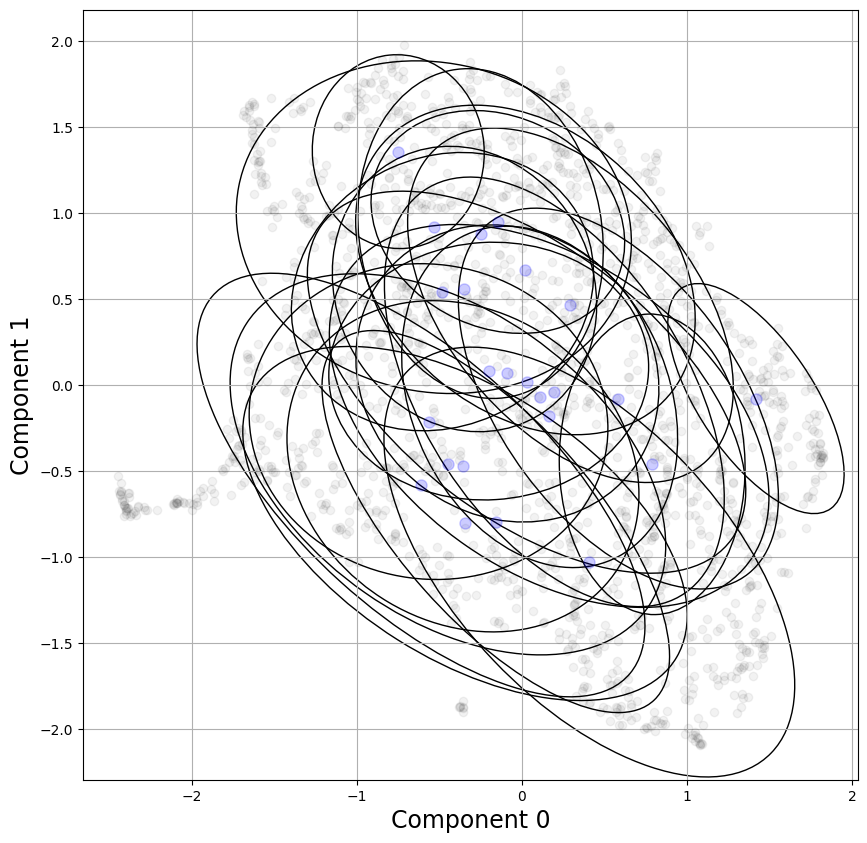

In [44]:
ellipse_plot(emb, dx["STUDY_PRTCPT_ID"], 0, 1)

# CORE

Covariance reduction to identify heteroscedasticity.

In [45]:
tab20 = matplotlib.colormaps["tab20"].colors

In [46]:
nobs = dx["STUDY_PRTCPT_ID"].value_counts()
nobs = pd.DataFrame({"STUDY_PRTCPT_ID": nobs.index, "nobs": nobs.values})
dy = pd.merge(dx, nobs, left_on="STUDY_PRTCPT_ID", right_on="STUDY_PRTCPT_ID")
dy = dy.loc[dy.nobs > 10, :]
idx = np.asarray(dy["STUDY_PRTCPT_ID"].astype(str))
X = np.asarray(dy[va2])
m = CORE(idx, X, 2)
r = m.fit(maxiter=1000)
qq = pd.DataFrame(r.params, va2, columns=["B%d" % j for j in range(2)])
qq

B0        B1
DEEP_MIN        -0.023837  0.006309
DEEP_COUNT       0.010733  0.019602
LIGHT_MIN       -0.075569  0.011818
LIGHT_COUNT     -0.031886 -0.009623
REM_MIN          0.009118  0.015914
REM_COUNT       -0.074905 -0.023370
WAKE_MIN        -0.009513  0.006203
WAKE_COUNT       0.017898  0.002628
SLEEP_START_SIN -0.929552  0.353286
SLEEP_START_COS -0.349883 -0.934713

<Figure size 640x480 with 0 Axes>

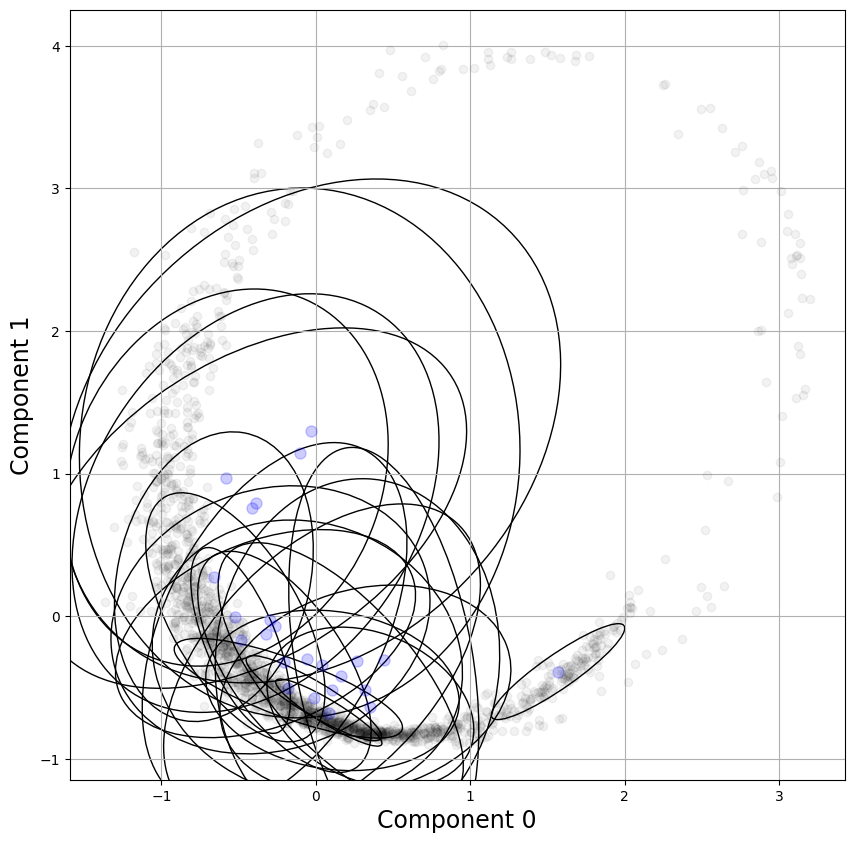

In [47]:
ellipse_plot(np.dot(X, r.params), dy["STUDY_PRTCPT_ID"], 0, 1)